## P1:  Max-Cut Problem

We will guide you through the design of a factor-2 approximation algorithm for the Max-Cut problem. You are given an undirected  graph $G$ with $n$ vertices and $m$ edges. 

The maxcut problem asks you to partition the vertices into two subsets $S^+$ and $S^-$ such that the total number of edges crossing the cut is as large as possible.
$$ \mathsf{max}\ \left| \left\{ (i,j) \in E\ |\ i \in S^+,\ j \in S^-,\ S^+ \cap S^- = \emptyset, S^+ \cup S^- = V \right\} \right|$$



### Example

Consider the graph below: 



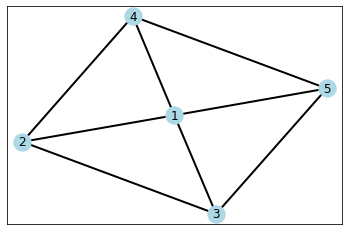

In [1]:
import networkx as nx
from matplotlib import pyplot as plt 

def draw_graph(n, edge_list, node_set_flag, set1_color='lightblue', set2_color='red'):
    # get the list of nodes in various sets and edges that are cut and uncut
    set1_nodes = [i for i in range(1, n+1) if node_set_flag[i-1] == True]
    set2_nodes = [i for i in range(1, n+1) if node_set_flag[i-1] == False]
    edge_list_not_cut = [(i,j) for (i,j) in edge_list if node_set_flag[i-1] == node_set_flag[j-1] ]
    edge_list_cut = [(i,j) for (i,j) in edge_list if node_set_flag[i-1] != node_set_flag[j-1] ]
    # now draw the graph
    G = nx.Graph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G, seed=1234)
    plt.figure()
    nx.draw_networkx_nodes(G, pos, nodelist=set1_nodes, node_color=set1_color)
    if len(set2_nodes) >= 1:
        nx.draw_networkx_nodes(G, pos, nodelist=set2_nodes, node_color=set2_color, alpha=0.5)
    
    labels = {i:i for i in range(1, n+1)}
    nx.draw_networkx_labels(G, pos,  labels=labels)
    
    nx.draw_networkx_edges(G, pos, width=2, edgelist = edge_list_not_cut)
    nx.draw_networkx_edges(G, pos, width=2, edgelist = edge_list_cut, edge_color='red')
    plt.show()
    

n = 5
edges = [(1,2),(1,3),(1,4),(1,5), (2,3),(2,4),(3,5),(4,5)]
node_set_flag = [True, True, True, True, True] # all nodes are in set1
draw_graph(5, edges, node_set_flag)


We would like to partition the set $\{ 1, \ldots, 5 \}$ into two subsets $S_1, S_2$ so that the number of edges going from a vertex in $S_1$ to a vertex in $S_2$ is as large as possible. 

#### First Cut
Suppose we set $S_1 = \{ 1, 2, 3\}$ and therefore, $S_2 = \{4, 5\}$, we have a cut with $4$ edges crossing it.

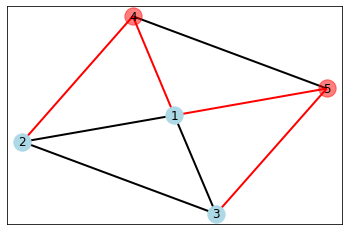

In [2]:
n = 5
edges = [(1,2),(1,3),(1,4),(1,5), (2,3),(2,4),(3,5),(4,5)]
node_set_flag = [True, True, True, False, False] # 1, 2, 3 are in set1
draw_graph(5, edges, node_set_flag)


#### Second Cut
We can do better by setting $S_1 = \{ 1,2,5\}$ and $S_2 = \{3, 4\}$ with $6$ edges crossing the cut. 

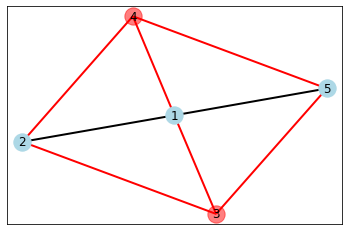

In [3]:
n = 5
edges = [(1,2),(1,3),(1,4),(1,5), (2,3),(2,4),(3,5),(4,5)]
node_set_flag = [True, True, False, False, True] # 1, 2, 5 are in set1
draw_graph(5, edges, node_set_flag)

Therefore, the MAXCUT problem asks you to find a cut with as many edges as possible crossing the cut. This problem is often encountered in applications such as circuit layout in chip design where we have a graph between the circuit components and the edges are formed by wires going between these components. 

MAXCUT is known to be NP-complete though we will not ask you to prove it here.  The goal of this problem is to design a greedy algorithm and prove an approximation guarantee.

## Greedy Algorithm 

Suppose you have a graph $G$ and we propose a partition of the vertices $S_1, S_2$. We say that a node $v$ is _imbalanced_ if it has strictly more number of edges  to other nodes within its  partition than edges crossing the cut. 

#### Examples 

As an example, consider the graphs shown above and the _first_ cut we showed above with $S_1 = \{1, 2, 3\}$ and $S_2 = \{4, 5\}$. Notice that vertices $2$ and $3$ are imbalanced.

However, if we consider the _second_ cut of the graph above, we have $S_1 = \{ 1, 2, 5\}$ and $S_2 = \{3, 4\}$ we see that all nodes are balanced in this cut.


### P1: Design a Greedy Algorithm

Design a greedy algorithm that starts from an arbitrary (random?) initial partition, detects if there are imbalanced vertices and uses that information to find a partition with a better cut.  Your algorithm should yield a partition with no imabalanced nodes in the final result.

Write down the pseudocode and prove that the algorithm terminates/find its time complexity.

__Note__ These problems are meant for you to develop your own thinking/problem solving and will not be graded due to the online nature of this class. We will be grading just the programming assignments based on test cases. The answers to select questions are given at the end of the notebook.

YOUR ANSWER HERE

### P2:  Implement the Greedy Algorithm 

Now let's implement the greedy algorithm to find a cut of the graph with no imbalanced vertices.

The graph will be given as an `adjacency list` representation. 

  - Vertex set will be $\{0, \ldots, n-1\}$ where $n$ (the number of vertices) is a input parameter.
  - `adj_list` is an adjacency list which is given as a list of sts. For instance `adj_list[i]` for a vertex $i$ is a _set_ to all vertices connected to vertex $i$. 
     - Note that since the graph is undirected, if $j$ lies in `adj_list[i]`, we know that $i$ will be in `adjacency_list[j]`.
     - You can assume that the graph has no self loops or multiple edges between same pairs of nodes.
  - We will specify a cut as a list of $n$ boolean values `[b0, b1,...bn-1]` wherein `bi` is `True` if $i \in S_1$, and `False` if vertex $i \in S_2$.
  

Implement the overall function `find_balanced_cut` that takes a graph as input and returns a list of Booleans specifying the final cut obtained by running the greedy algorithm. Please pay attention to efficiency, we will be running some large graphs through your code and it should run within a few seconds on graphs with thousands of nodes. 

In [15]:
def visualize_network(n, edge_list, cut):
    draw_graph(n, [(i+1, j+1) for (i,j) in edge_list], cut)
    return None

In [16]:
def find_edges_crossing_partition(n, adj_list, cut):
    within_partition = {i: [] for i in range(n)}
    cut_partition = {i: [] for i in range(n)}

    for source_node, compare_nodes in enumerate(adj_list):
        for compare_node in compare_nodes:
            r = cut[source_node] + cut[compare_node]
            # Means one of the node is in the other partition
            if r == 1:
                cut_partition[source_node].append(compare_node)
            else:
                within_partition[source_node].append(compare_node)
    return within_partition, cut_partition

def find_imbalance_nodes(within_partition, cut_partition):
    # imbalance = edges within partition > edges cut partition
    imbalanced_nodes = []
    for node in within_partition.keys():
        if len(within_partition[node]) > len(cut_partition[node]):
            imbalanced_nodes.append(node)
    return imbalanced_nodes

In [17]:
# This is the function that you will implement the greedy algorithm
# It should input a graph as an adjacency list and return a partition where 
# every vertex is balanced, as described above.
# Return a list of Booleans of size n, wherein for any vertex v, if list[v] = True then 
# it belongs to partition S1 otherwise to partition S2.
def find_balanced_cut(n, adj_list): 
    assert n >= 1
    assert len(adj_list) == n
    # Check that the adjacency list makes sense and represents a directed graph
    for (i, neighbors) in enumerate(adj_list):
        assert all( 0 <= j < n for j in neighbors )
        assert i not in neighbors # no self loops allowed
        for j in neighbors: 
            assert i in adj_list[j]
    # just start with an initial cut tthat places first n/2 nodes in S1 and rest in S2.
    cut = [True if i < n/2 else False for i in range(n)]
    ## TODO: now run the greedy algorithm. It will be helpful to have helper functions to find 
    ## imbalanced_vertices, maintain an array with the number of edges for each node that are cut and so on.
    ## Note: your algorithm must return a cut where all nodes are balanced.
    # your code here
    within_partition, cut_partition = find_edges_crossing_partition(n, adj_list, cut)
    imbalanced_nodes = find_imbalance_nodes(within_partition, cut_partition)

    while len(imbalanced_nodes) != 0:
        idx = imbalanced_nodes[0]
        cut[idx] = not(cut[idx])
        within_partition, cut_partition = find_edges_crossing_partition(n, adj_list, cut)
        imbalanced_nodes = find_imbalance_nodes(within_partition, cut_partition)

    return cut

In [18]:
#These  are useful functions for the test cases
# IMPORTANT: 
# Please ensure that you run these cells before running test cases or else you may get unknown function errors.

# Make an adjacency list out of a list of edges.
def mk_adjacency_list(n, edge_list):
    adj_list = [set() for i in range(n)]
    for (i,j) in edge_list:
        adj_list[i].add(j)
        adj_list[j].add(i)
    return adj_list

# Test Partition
def test_cut(n, adj_list, cut):
    num_edges_crossing_cut = [0]*n
    for (i, neighbors) in enumerate(adj_list):
        num_edges_crossing_cut[i] = sum([cut[i] != cut[j] for j in neighbors])
        if 2 * num_edges_crossing_cut[i] < len(neighbors):
                assert f'Test Failed: In your cut, vertex {i} has {len(neighbors)} edges incident on it but only {num_edges_crossing_cut[i]} edges cross the cut'
    return 
    

In [19]:
n = 5
edge_list =  [(0,1),(0,2),(0,3),(0,4), (1,2),(1,3),(2,4),(3,4)]
adj_list = mk_adjacency_list(n, edge_list)
print(f'Adjacency list is {adj_list}')
cut = find_balanced_cut(n, adj_list)
test_cut(n, adj_list, cut)
print('Tests Passed (5 points)')

Adjacency list is [{1, 2, 3, 4}, {0, 2, 3}, {0, 1, 4}, {0, 1, 4}, {0, 2, 3}]
Tests Passed (5 points)


In [20]:
n = 8
edge_list = [ (0,1), (0,2), (0,3), (0,4), (0,5), (0,6),
               (1, 2), (1,3), (1,4), (1,5), (1, 6), (1,7),
                 (2, 3), (2, 5), (2, 7), 
                   (3,4), (3, 6), (3, 7),
                     (4,6), (4, 6), (4, 7),
                        (5,6), (5,7),
                         (6,7)]
adj_list = mk_adjacency_list(n, edge_list)
print(f'Adjacency list is {adj_list}')
cut = find_balanced_cut(n, adj_list)
test_cut(n, adj_list, cut)

print('Tests Passed (5 points)')

Adjacency list is [{1, 2, 3, 4, 5, 6}, {0, 2, 3, 4, 5, 6, 7}, {0, 1, 3, 5, 7}, {0, 1, 2, 4, 6, 7}, {0, 1, 3, 6, 7}, {0, 1, 2, 6, 7}, {0, 1, 3, 4, 5, 7}, {1, 2, 3, 4, 5, 6}]
Tests Passed (5 points)


In [21]:
## WARNING: these graphs are going to be large. Make sure that your code is efficient enough to finish running this cell
## within 1 minute at worst.
## Our referene solution finishes in nearly 100 milli seconds on a macbook pro laptop
# running intel core i7 3.1 GHz processor
# if you are curious.
from random import randint
def mk_random_graph(n, m):
    adj_list = [set() for i in range(n)]
    for k in range(m):
        i = randint(0, n-1)
        j = randint(0, n-1)
        if i == j: 
            continue
        adj_list[i].add(j)
        adj_list[j].add(i)
    return adj_list


adj_list = mk_random_graph(100, 1000) # making random graph with 100 nodes and 10000 edges
cut = find_balanced_cut(100, adj_list)
test_cut(100, adj_list, cut)


adj_list = mk_random_graph(100, 1000) # making random graph with 100 nodes and 1000 edges
cut = find_balanced_cut(100, adj_list)
test_cut(100, adj_list, cut)


adj_list = mk_random_graph(250, 2500) # making random graph with 250 nodes and 2500 edges
cut = find_balanced_cut(250, adj_list)
test_cut(250, adj_list, cut)



adj_list = mk_random_graph(500, 10000) # making random graph with 250 nodes and 2500 edges
cut = find_balanced_cut(500, adj_list)
test_cut(500, adj_list, cut)

print('Test Passed (15 points)')


Test Passed (15 points)


### Q3. Approximation Guarantee

Suppose we have a graph $G$ and a partition $S_1, S_2$ of its vertices such that there are no imbalanced vertices. Show that at least half the edges in the graph must connect a node from $S_1$ to one in $S_2$. 

Therefore, show that the greedy algorithm is a factor-2 approximation algorithm: I.e, if OPT is the optimal cut and $C$ is that of the greedy algorithm, we have: 

$$ \frac{1}{2} \text{OPT} \leq C \leq OPT $$

YOUR ANSWER HERE

# P2: k-Centers Clustering Problem

You are given a set of points $P_1, \ldots, P_n$ on a plane where for each point $P_i$ we provide its coordinates $(x_i, y_i)$. The goal is to select $k$ points out of $n$ as _centers_. Once we select $k$ such centers $C_1, \ldots, C_k$ from among the points $P_1, \ldots, P_n$, we define for every point $P_i$ the distance $r_i$ as the distance from $P_i$ to its nearest center: 
$$ r_i = \min_{j=1}^k \mathsf{distance}(P_i, C_j) \,.$$

Here we use Euclidean distance: $\mathsf{distance}( (x_1, y_1), (x_2, y_2) ) = \sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2 }$. Also note that the distance $r_i$ depends on which points we choose as centers. 
For instance, if a point $P_i$ is chosen as one of the centers, then its distance $r_i = 0$.

Having chosen $k$ centers $C_1, \ldots, C_k$,  we define $R(C_1, \ldots, C_k) = \max ( r_1, \cdots, r_n )$ as the maximum distance from any point to its nearest center. It is clear then that if we placed a circle of radius $R(C_1, \ldots, C_k)$ around every center, then all points belong to the circle. 


Our goal is to choose $k$ centers such that we minimize the value of $R$ as defined above.
$$ \mathsf{find\ centers}\ C_1, \ldots, C_k \ \mathsf{s.t.}\ R(C_1, \ldots, C_k)\ \mathsf{is\ minimized} $$


## Example

Suppose we have $10$ points $P_1, \ldots, P_{10}$ with the coordinates: 
$$P_1: (1,2),\ P_2:(3,5),\ P_3:(4,7),\ P_4:(8, 14),\ P_5:(9,3),\ P_6:(7,7),\ P_7:(6,5),\ P_8:(4, 6),\ P_9:(5,2),\ P_{10}:(1,8)\,.$$
We choose $k=2$ centers whose indices are in the list `center_indices`. In this instance, we have chosen  $P_3$ and $P_7$. The calculation of $R(C_1, C_2)$ proceeds as shown below to obtain the value $R = 8.062$.

R = 8.06225774829855


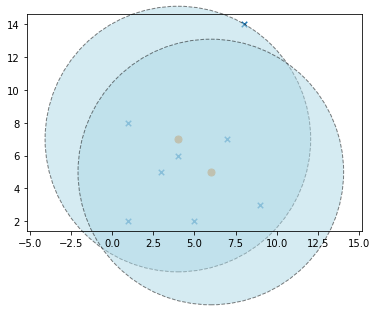

In [22]:
from math import sqrt 
from matplotlib import pyplot as plt 


def euclidean_distance(a, b):
    (xa, ya) = a
    (xb, yb) = b
    return sqrt( (xb - xa)**2 + (yb - ya)**2)

def calculate_R(coords, center_indices):
    n = len(coords)
    assert all( 0 <= j < n for j in center_indices)
    rj_values = [ min([euclidean_distance(xj, coords[j]) for j in center_indices]) for xj in coords]
    return max(rj_values)

def plot_coords(coords, center_indices):
    R = calculate_R(coords, center_indices)
    coords_x = [x for (x,y) in coords]
    coords_y = [y for (x, y) in coords]
    centers_x = [coords_x[j] for j in center_indices]
    centers_y = [coords_y[j] for j in center_indices]
    figure, axes = plt.subplots()
    axes.axis('equal')
    for k in center_indices:
        c = plt.Circle(coords[k], R, fill=True, alpha=0.5, facecolor='lightblue', clip_on=False, edgecolor='black', linewidth=1, linestyle='dashed')
        axes.add_artist(c)
    plt.scatter(coords_x, coords_y, s=30, marker='x' )
    plt.scatter(centers_x, centers_y, s=50, marker='o')
    plt.show()
    
coords = [(1,2), (3,5), (4,7), (8, 14), (9,3), (7,7), (6,5), (4, 6), (5,2), (1,8)]
center_indices = [2, 6] # remember indexing starts from 0 in python arrays
R = calculate_R(coords, center_indices)
print(f'R = {R}')
plot_coords(coords, center_indices)
    

However, if we instead chose centers: $P_2$ and $P_{6}$, we obtain a smaller $R = 7.071$.

R = 7.0710678118654755


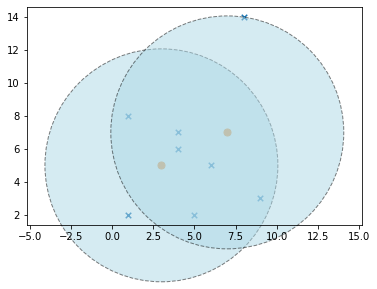

In [23]:
coords = [(1,2), (3,5), (4,7), (8, 14), (9,3), (7,7), (6,5), (4, 6), (5,2), (1,8)]
center_indices = [1, 5] # remember indexing starts from 0 in python arrays
R = calculate_R(coords, center_indices)
print(f'R = {R}')
plot_coords(coords, center_indices)

In the example above, we are asking which set of $k=2$ centers will yield the minimum radius $R$. 

## Solving the k-center problem

The k-center problem is well known to be NP-complete. The obvious algorithm of running through all possible $k$ combinations out of the given set of $n$ points has a complexity $O(n^k)$ which is exponential in $k$.

How do we solve the $k$-center problem in a greedy manner? Here is a simple algorithm:

<div class="alert alert-info" style=" border-width:2px;border-color:black white black white;">
    <ol>
        <li> $C = \{ P_1 \} $. <i> Just add the first point to the list of centers </i>
        <li> for j = 2 to k
            <ol>
                <li> $(P_j, r_j) = \mathit{find\_farthest\_point\_from\_current\_centers}( [P_1, \ldots, P_n], C ) $
                <li> $C = C \cup \{ P_j \}$
            </ol>  
        <li> $ (P_{k+1}, R) = \mathit{find\_farthest\_point\_from\_current\_centers}( [P_1, \ldots, P_n], C ) $
        <li> return set of centers $C$, radius $R$
    </ol>
</div>

The function $\mathit{find\_farthest\_point\_from\_current\_centers}$ goes over all points in the list and returns the point $P_j$ whose distance from its closest center $r_j$ is the maximum amongst all points. Although the function just needs to return this point $P_j$, we will also make it return $r_j$. Similarly the call to this function after the loop has finished is not needed but it will be useful to our analysis of this algorithm later on. 

In [24]:
def euclidean_distance(a, b):
    (xa, ya) = a
    (xb, yb) = b
    return sqrt( (xb - xa)**2 + (yb - ya)**2)


# Function find_farthest_point_from_current_centers
# returns a pair (j, rj) where 
# - 0 <= j < len(coords) is the index of the farthest point P_j
# - rj is the distance of the point P_j from its nearest center
def find_farthest_point_from_current_centers(coords, center_indices):
    n = len(coords)
    assert all( 0 <= j < n for j in center_indices)
    rj_values = [ (min([euclidean_distance(xi, coords[j]) for j in center_indices]), i) for (i, xi) in enumerate(coords)]
    (rj, j) = max(rj_values)
    return (j, rj)

## Implement a function greedy_k_centers that given a list of coordinates `coords`, returns center_list, R
##   - centers_list is a list of indices [j1,..., jk]. Note that coords[j1], ..., coords[jk] will yield coordinates of the actual centetr.
##   - R is the radius resulting from the choice of the k centers
## Please use the implementation of find_farthest_point_from_current_centers above.
def greedy_k_centers(coords, k, debug=True): ## Please print messages from this function only if debug flag is True
    centers = [0] # Add the very first point 
    R = []
    if debug:
        print(f'Initial center: {coords[0]}')
    # your code here
    for _ in range(1, k):
        j, rj = find_farthest_point_from_current_centers(coords, centers)
        centers.append(j)
    _, R = find_farthest_point_from_current_centers(coords, centers)
    return centers, R

Initial center: (1, 2)


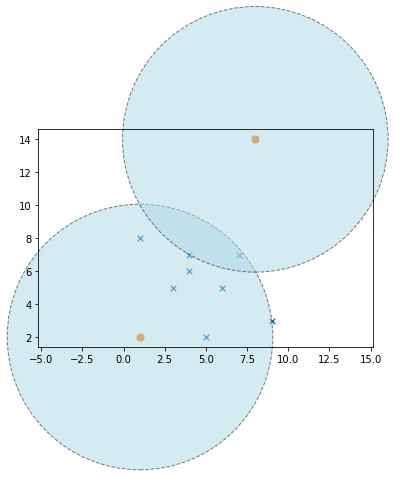

Passed test (5 points)


In [25]:
coords = [(1,2), (3,5), (4,7), (8, 14), (9,3), (7,7), (6,5), (4, 6), (5,2), (1,8)]
(center_indices, R) = greedy_k_centers(coords, 2)
plot_coords(coords, center_indices)
def calculate_R(coords, center_indices):
    n = len(coords)
    assert all( 0 <= j < n for j in center_indices)
    rj_values = [ min([euclidean_distance(xj, coords[j]) for j in center_indices]) for xj in coords]
    return max(rj_values)

assert len(center_indices) == 2
assert abs(R - calculate_R(coords, center_indices)) <= 1E-06, f'The returned value of R={R} from your function does not match with my computation. Something is wrong in your calculations'
assert 4 <= R <= 16.2
print('Passed test (5 points)')

Initial center: (1, 2)


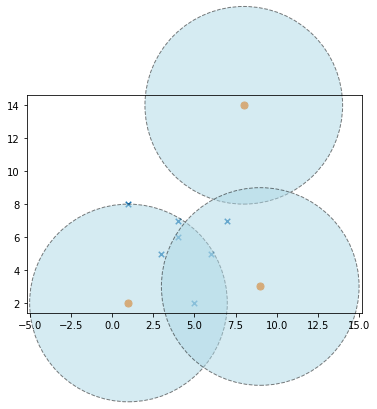

Passed test (5 points)


In [26]:
coords = [(1,2), (3,5), (4,7), (8, 14), (9,3), (7,7), (6,5), (4, 6), (5,2), (1,8)]
(center_indices, R) = greedy_k_centers(coords, 3)
plot_coords(coords, center_indices)
def calculate_R(coords, center_indices):
    n = len(coords)
    assert all( 0 <= j < n for j in center_indices)
    rj_values = [ min([euclidean_distance(xj, coords[j]) for j in center_indices]) for xj in coords]
    return max(rj_values)

assert len(center_indices) == 3
assert abs(R - calculate_R(coords, center_indices)) <= 1E-06, f'The returned value of R={R} from your function does not match with my computation. Something is wrong in your calculations'
assert 3 <= R <= 12.0
print('Passed test (5 points)')

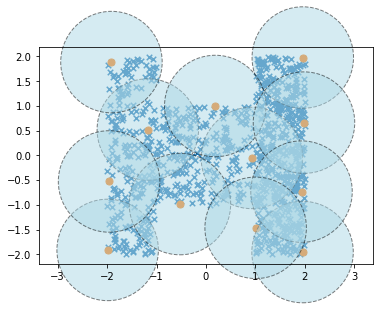

Test Passed (5 points)


In [27]:
from random import uniform
## Generate 1000 points
n = 1000
k = 12
coords = [(uniform(-2,-1), uniform(-2,2)) for i in range(n//4)] + [(uniform(-1,1), uniform(-1,1)) for i in range(n//4)] +  [(uniform(1,2), uniform(-2,0)) for i in range(n//4)] +  [(uniform(1,2), uniform(0,2)) for i in range(n//4)] 
            
(center_indices, R) = greedy_k_centers(coords, k, debug=False)
plot_coords(coords, center_indices)
def calculate_R(coords, center_indices):
    n = len(coords)
    assert all( 0 <= j < n for j in center_indices)
    rj_values = [ min([euclidean_distance(xj, coords[j]) for j in center_indices]) for xj in coords]
    return max(rj_values)

assert len(center_indices) == k
assert abs(R - calculate_R(coords, center_indices)) <= 1E-06, f'The returned value of R={R} from your function does not match with my computation. Something is wrong in your calculations'
print('Test Passed (5 points)')

## Analysis

Let's recall the greedy algorithm again. 


<div class="alert alert-info" style=" border-width:2px;border-color:black white black white;">
    <ol>
        <li> $C = \{ P_1 \} $. <i> Just add the first point to the list of centers </i>
        <li> for j = 2 to k
            <ol>
                <li> $(C_j, r_j) = \mathit{find\_farthest\_point\_from\_current\_centers}( [P_1, \ldots, P_n], C ) $
                <li> $C = C \cup \{ C_j \}$
            </ol>  
        <li> $ (P_{k+1}, R) = \mathit{find\_farthest\_point\_from\_current\_centers}( [P_1, \ldots, P_n], C ) $
        <li> return set of centers $C$, radius $R$
    </ol>
</div>


Let $C_1, C_2, \ldots, C_k$ be the set of centers it returns and $P_{k+1}$ be the point returned by the call to $ \mathit{find\_farthest\_point\_from\_current\_centers}$ in line 3 of the algorithm. Note that $C_1 = P_1$ the way we have written the algorithm.


#### Q1

How do the radii $r_2, \ldots, r_k$ obtained in the main for-loop of the algorithm and the final value $R$ compare with each other?



YOUR ANSWER HERE

Let us suppose the optimal algorithm chose centers $O_1, \ldots, O_k$ which yielded radius $R^*$. In other words every point can be found within $R^*$ circle around the centers $O_1, \ldots, O_k$. 

If we consider the points chosen by the greedy algorithm and the point $P_{k+1}$ generated after the $k$ centers are found, these $k+1$ points must also be covered by the $k$ optimal centers and the circles of radius $R^*$ around these. Therefore, by pigeon hole principle at least $2$ of the points in the set 
 $$ \{ C_1, \ldots, C_k, P_{k+1} \}$$ 
 must lie within the same circle centered around some optimal center $O_i$. 
 
 __Q2__
 
 What is the farthest possible distance between any two points in a circle of radius $2 R^*$?

YOUR ANSWER HERE

__Q3__

Suppose we take any two distinct points in the set $ \{ C_1, \ldots, C_k, P_{k+1} \}$. What can you say about the distance between them?

YOUR ANSWER HERE

Show that the radius $R$ found by the greedy algorithm and the optimal radius $R^*$ must satisfy the inequality 
$ R^* \leq R \leq 2 R^* $. And therefore, the greedy algorithm is a factor $2$ approximation.


YOUR ANSWER HERE

# Answers to Manually Graded Problems

### P1: Design a Greedy Algorithm

The pseudo code goes like this

<div class="alert alert-block alert-info" style="border-width:2px; border-color: black white black white ">
    <ol>
        <li> Start by assigning first $n/2$ nodes to $S_1$ and remaining to $S_2$ (or some arbitrary initial partition).
        <li> while <i> there exists an imbalanced node in partition $(S_1, S_2)$ </i> 
            <ol>
                <li> $v\ :=\ \textit{findImbalancedNode}(G, S_1, S_2) $
                <li> Flip the current partition that $v$ is in (i.e, if $v \in S_1$ then move $v$ to $S_2$ or vice-versa).
            </ol>
         <li> return $(S_1, S_2)$
    </ol>
</div>

The algorithm terminates because at each step, it moves when it moves an imbalanced node from one partition to another, the number of edges that are currently crossing the cut strictly increases. Since the maximum number of edges is limited by total number of edges in the graph, the algorithm must terminate. 

The time complexity of the algorithm is $ O(|E| \times (|V| + |E|))$. The greedy algorithm runs for at most $|E|$ steps and each iteration searches over the graph to find an imbalanced node. Obviously we can improve this with some better data-structures that can do the book keeping efficiently.
    
### P1: MaxCut, Q3. Approximation Guarantee

Suppose the partition has the property that no node is imbalanced. Then for every node, let $\text{ncut}(v)$ represent the number of edges incident on $v$ that cross the cut and $\delta(v)$ reprent the number of edges incident on $v$. We know that for all $v$, 

$$  \text{ncut}(v) \geq \frac{1}{2} \delta(v) $$

Summing over all nodes $v$, 

$$ \sum_{v \in V} \text{ncut}(v) \geq \frac{1}{2} \sum_{v \in V} \delta(v) $$

The LHS of the summation is twice the size of the cut because every edge $(u,v)$ is counted twice once as part of $\text{ncut}(u)$ and once more as part of $\text{ncut}(v)$. The RHS is the number of edges in the graph. Therefore, if $C$ is the size of the cut, we have

$$ 2  C \geq |E|,\ \text{or}\ C \geq \frac{1}{2} |E|$$

However, the optimal cut OPT cannot exceed $|E|$ in the first place. Hence we have

$$ \frac{1}{2} \text{OPT} \leq C \leq OPT $$


### P2: k-center, Q1

Note that each $r_j$ is the distance of the point in the list that is farthest from the current set of centers $C_1, \ldots, C_{j-1}$. Therefore, we have

$$r_2 \geq r_3 \geq \cdots \geq r_k \geq R $$

I.e, as the algorithm runs, each new center is closer to the previously generated set of centers.

### Q2

Answer $2 R^*$: two points along some diameter.

### Q3
Suppose we chose two points $C_i, C_j$ that are centers chosen by the greedy algorithm and $i < j$. We know that $C_j$ was the farthest points from any of the centers $C_1, \ldots, C_{j-1}$. Therefore, the distance between $C_i, C_j$ must be _at least_ $r_j$ and which is at least $R$.

Similarly if we chose points $C_i, P_{k+1}$ the same fact holds. Distance between the points must be _at least_ at least $R$.

### Q4

By pigeon hole principle at least two of the points in the set  $ \{ C_1, \ldots, C_k, P_{k+1} \}$ must lie inside a circle of radius $R^*$. However, any two points in the set must have a distance of at least $R$. Hence, 
$$ R \leq 2 R^*$$.

Showing $R^* \leq R$ is obvious by assumption that $R^*$ is an optimal radius for the k-center problem and $R$ is some sub-optimal solution.
